In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/GIL/
!python dataset_splitting.py

#Importing Important Liberaries



In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras import Model
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

In [ ]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

train_dir = '/content/drive/MyDrive/GIL/catsVSdogs/train'
validation_dir = '/content/drive/MyDrive/GIL/catsVSdogs/val'
test_dir = '/content/drive/MyDrive/GIL/catsVSdogs/test'

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

####Adding l2 Regularization to VGG19
#####After Many experiments with LEARNING RATE and Gradient Descent Functions to handle overfitting but did not get the results i want so i decide to add regularization in VGG19 after every conv2D layer.

In [ ]:
regularizer = l2(0.001)
print(f'model.losses (original): {conv_base.losses}')

for i in range(len(conv_base.layers)):
  if isinstance(conv_base.layers[i], layers.Conv2D):
    print('Adding regularizer to layer {}'.format(conv_base.layers[i].name))
    conv_base.layers[i].kernel_regularizer = regularizer
print(f'model.losses (after setting reg): {conv_base.losses}')


model.losses (original): []
Adding regularizer to layer block1_conv1
Adding regularizer to layer block1_conv2
Adding regularizer to layer block2_conv1
Adding regularizer to layer block2_conv2
Adding regularizer to layer block3_conv1
Adding regularizer to layer block3_conv2
Adding regularizer to layer block3_conv3
Adding regularizer to layer block3_conv4
Adding regularizer to layer block4_conv1
Adding regularizer to layer block4_conv2
Adding regularizer to layer block4_conv3
Adding regularizer to layer block4_conv4
Adding regularizer to layer block5_conv1
Adding regularizer to layer block5_conv2
Adding regularizer to layer block5_conv3
Adding regularizer to layer block5_conv4
model.losses (after setting reg): []


######Defining the extract_feature function

In [ ]:
def extract_features(directory, sample_count):
	features = np.zeros(shape=(sample_count, 4, 4, 512))
	labels = np.zeros(shape=(sample_count))
	generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
	i = 0
	for inputs_batch, labels_batch in generator:
		features_batch = conv_base.predict(inputs_batch)
		features[i * batch_size : (i+1) * batch_size] = features_batch
		labels[i * batch_size : (i+1) * batch_size] = labels_batch
		i += 1
		if i * batch_size >= sample_count:
			break
	return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 18ms/step


###Flattening the data for Dense Layer


In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
#With Data Augumentation
model = models.Sequential()
model.add(conv_base)
#model.summary()
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


###Applying Data Augumentation on data and reshaping them according to vgg19 input layer

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary')


validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=4e-5), metrics=['accuracy'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
checkpoint_path = "/content/drive/MyDrive/GIL/trained_model.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [ ]:
#history = model.fit_generator(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=40, validation_data=validation_generator, validation_steps=50, callbacks=[cp_callback])

<ipython-input-74-08bb1e0324f5>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=40, validation_data=validation_generator, validation_steps=50, callbacks=[cp_callback])


Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.5675
Epoch 1: saving model to /content/drive/MyDrive/GIL/trained_model.ckpt
100/100 [==============================] - 79s 286ms/step - loss: 0.6788 - accuracy: 0.5675 - val_loss: 0.5719 - val_accuracy: 0.7290
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.5452 - accuracy: 0.7155
Epoch 2: saving model to /content/drive/MyDrive/GIL/trained_model.ckpt
100/100 [==============================] - 30s 302ms/step - loss: 0.5452 - accuracy: 0.7155 - val_loss: 0.3832 - val_accuracy: 0.8700
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8225
Epoch 3: saving model to /content/drive/MyDrive/GIL/trained_model.ckpt
100/100 [==============================] - 30s 298ms/step - loss: 0.4223 - accuracy: 0.8225 - val_loss: 0.2495 - val_accuracy: 0.8960
Epoch 4/40
100/100 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8470
E

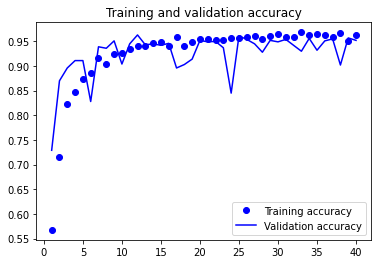

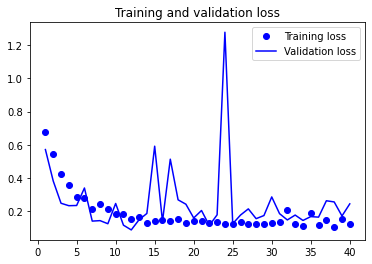

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###Evaluating the Model On Testing Data

In [ ]:
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(test_generator, verbose=2)

print("Accuracy: {:5.2f}%".format(100 * acc))

50/50 - 296s - loss: 0.4322 - accuracy: 0.9500 - 296s/epoch - 6s/step
Accuracy: 95.00%


##Saving the model

In [ ]:
model.save('/content/drive/MyDrive/GIL/vgg19.model')

In [ ]:
model.save('/content/drive/MyDrive/GIL/my_model.h5')

###Visualiztion of Testing Data

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(r'/content/drive/MyDrive/GIL/vgg19.model')

18/50 [=========>....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

16/50 [========>.....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

16/50 [========>.....................] - ETA: 0s

16/50 [========>.....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

16/50 [========>.....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

16/50 [========>.....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

15/50 [========>.....................] - ETA: 0s

50/50 [==============================] - 0s 3ms/step


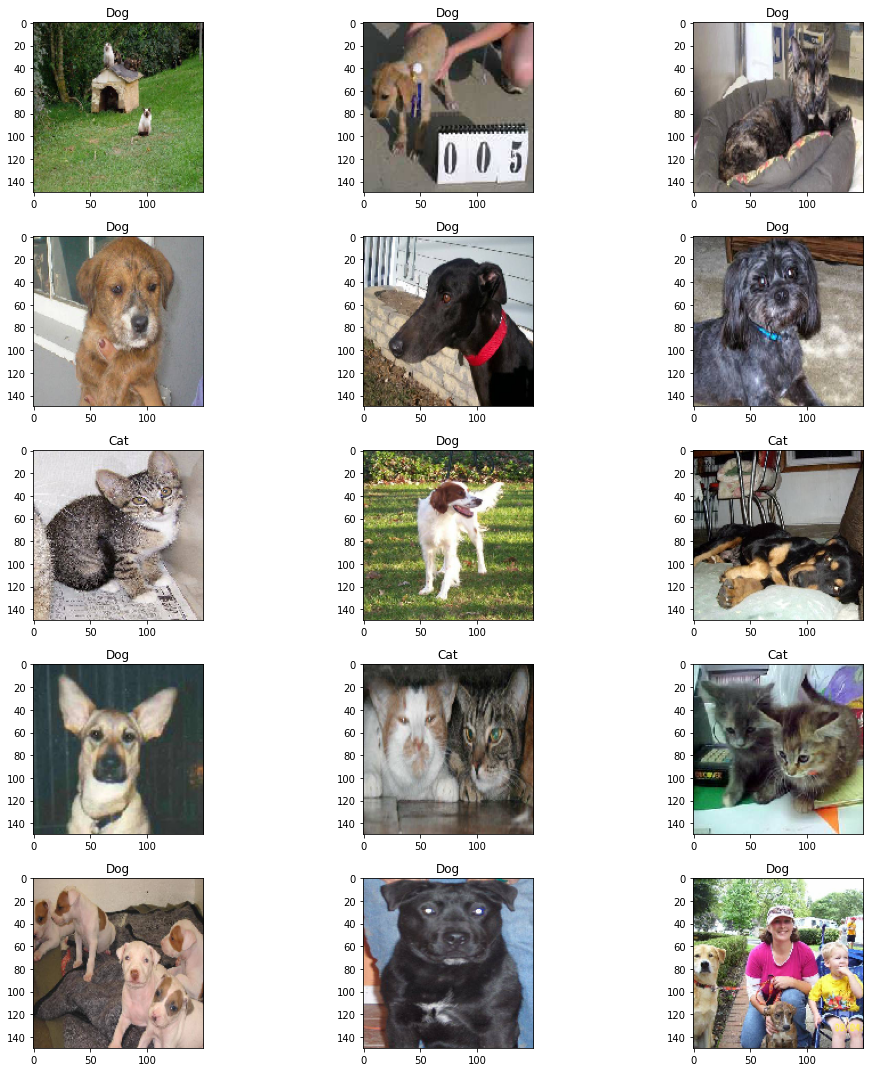

In [ ]:
def visualize_predictions(test_generator, model):
    plt.figure(figsize=(15, 15))
    for i in range(0, 15):
        plt.subplot(5, 3, i+1)
        for X_batch in test_generator:
            prediction = model.predict(X_batch[0], steps=np.ceil(1000/batch_size))
            image = X_batch[0]
            plt.imshow(image[0])
            plt.title('Dog' if np.argmax(prediction)==0 else "Cat")
            break
    plt.tight_layout()
    plt.show()
visualize_predictions(test_generator, model)

####Evaluate Model Live on Camera

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


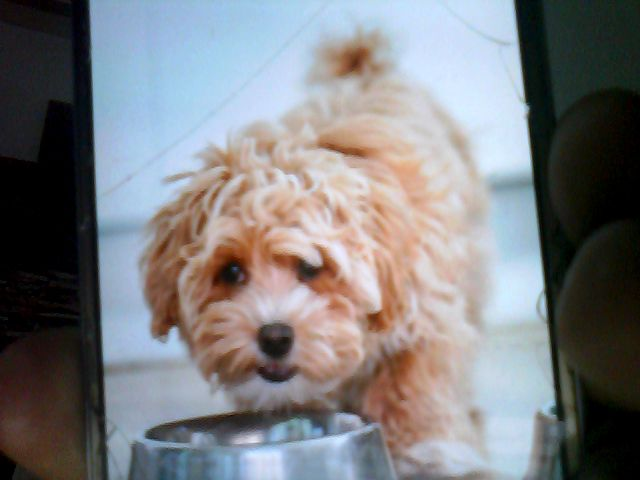

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  
  
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
ing = cv2.imread('/content/photo.jpg')
print(ing.shape)
img = np.array(ing)
img = np.resize(img, (1, 150, 150, 3))
prediction = model.predict(img)
print('Dog' if np.argmax(prediction)==0 else "Cat")

(480, 640, 3)
1/1 [==============================] - 0s 17ms/step
Dog
